# LSTM Text Classification Training

This notebook trains a simple LSTM model for text classification.

📌 **Expectations:**
- Uses F1 as the **primary** evaluation metric
- Saves accuracy/F1 curves and a **confusion matrix**
- Produces a small PDF results report

🔧 **Dataset format**: CSV with columns `text` and `label`. Set `DATASET_PATH` below.


In [1]:

# If running on Colab, uncomment the next line
!pip install torch torchvision torchaudio torchtext==0.18.0 scikit-learn pandas matplotlib reportlab tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.9 MB/s eta 0:00:00


In [2]:


import os, math, random, pandas as pd, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from datetime import datetime

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# ---- Paths ----
DATASET_PATH = "/content/dataset.csv"  # <-- change this
OUT_DIR = "outputs_lstm"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Hyperparams ----
MAX_LEN = 128
BATCH_SIZE = 64
EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_EPOCHS = 5
LR = 1e-3


In [3]:

# ---------------- Data ----------------
df = pd.read_csv(DATASET_PATH)
assert "text" in df.columns and "label" in df.columns, "CSV must have columns: text, label"

# Encode labels
le = LabelEncoder()
df["y"] = le.fit_transform(df["label"].astype(str))

# Simple tokenizer (whitespace + frequency vocab)
# For production, prefer a real tokenizer, but this keeps it dependency-light for an LSTM example.
def tokenize(s):
    return str(s).lower().split()

# Build vocab
from collections import Counter
all_tokens = [tok for s in df["text"].astype(str).tolist() for tok in tokenize(s)]
freq = Counter(all_tokens)
# keep top N words
MAX_VOCAB = 20000
vocab_words = [w for w,_ in freq.most_common(MAX_VOCAB-2)]
stoi = {"<pad>":0, "<unk>":1}
for i,w in enumerate(vocab_words, start=2):
    stoi[w] = i
itos = {i:w for w,i in stoi.items()}

def encode(s, max_len=MAX_LEN):
    toks = tokenize(s)
    ids = [stoi.get(t,1) for t in toks][:max_len]
    if len(ids) < max_len:
        ids = ids + [0]*(max_len-len(ids))
    return ids

X = np.stack([encode(s) for s in df["text"].astype(str)])
y = df["y"].values
num_classes = len(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

class TxtDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

tr_loader = DataLoader(TxtDS(X_train,y_train), batch_size=BATCH_SIZE, shuffle=True)
va_loader = DataLoader(TxtDS(X_val,y_val), batch_size=BATCH_SIZE)
te_loader = DataLoader(TxtDS(X_test,y_test), batch_size=BATCH_SIZE)


In [4]:

# ---------------- Model ----------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, x):
        x = self.emb(x)                # [B, T, E]
        out,_ = self.lstm(x)           # [B, T, 2H]
        out = out[:, -1, :]            # last timestep
        out = self.drop(out)
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(vocab_size=len(stoi), embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


Epoch 01 | loss 1.0981 | acc 0.3375 | F1 0.1703
Epoch 02 | loss 1.0986 | acc 0.3375 | F1 0.1703
Epoch 03 | loss 1.0990 | acc 0.3375 | F1 0.1703
Epoch 04 | loss 1.0985 | acc 0.3375 | F1 0.1703
Epoch 05 | loss 1.0983 | acc 0.3250 | F1 0.1594

TEST -> loss 1.0988 | acc 0.3250 | F1 0.1594
Saved PDF -> outputs_lstm/LSTM_results.pdf


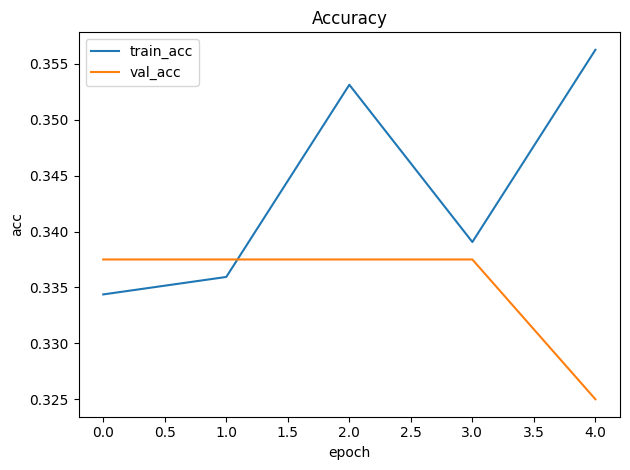

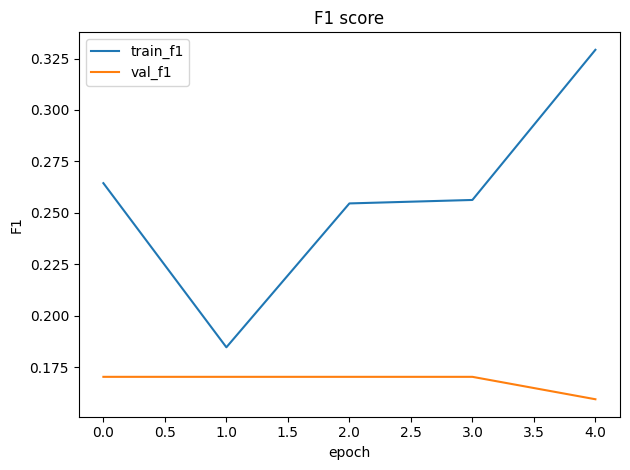

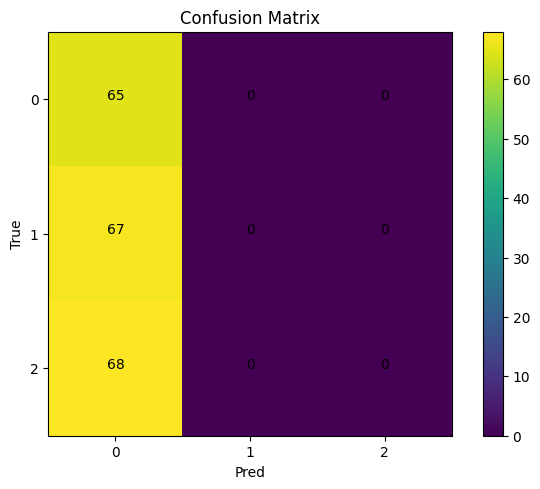

In [5]:

# ---------------- Train & Eval ----------------
def run_epoch(loader, train=True):
    if train: model.train()
    else: model.eval()
    losses, preds, gts = [], [], []
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            if train: optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
            losses.append(loss.item())
            preds.extend(torch.argmax(logits, dim=-1).detach().cpu().tolist())
            gts.extend(yb.detach().cpu().tolist())
    return np.mean(losses), accuracy_score(gts, preds), f1_score(gts, preds, average="weighted"), np.array(preds), np.array(gts)

history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}
for epoch in range(1, NUM_EPOCHS+1):
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(tr_loader, train=True)
    va_loss, va_acc, va_f1, _, _ = run_epoch(va_loader, train=False)
    history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)
    print(f"Epoch {epoch:02d} | loss {va_loss:.4f} | acc {va_acc:.4f} | F1 {va_f1:.4f}")

te_loss, te_acc, te_f1, te_pred, te_true = run_epoch(te_loader, train=False)
print("\nTEST -> loss {:.4f} | acc {:.4f} | F1 {:.4f}".format(te_loss, te_acc, te_f1))

# --- Plots ---
plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.tight_layout()
acc_png = os.path.join(OUT_DIR, "accuracy.png"); plt.savefig(acc_png, dpi=150)

plt.figure()
plt.plot(history["train_f1"], label="train_f1")
plt.plot(history["val_f1"], label="val_f1")
plt.title("F1 score"); plt.xlabel("epoch"); plt.ylabel("F1"); plt.legend(); plt.tight_layout()
f1_png = os.path.join(OUT_DIR, "f1.png"); plt.savefig(f1_png, dpi=150)

# Confusion matrix
cm = confusion_matrix(te_true, te_pred, labels=list(range(num_classes)))
plt.figure()
import itertools
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center")
plt.tight_layout(); plt.ylabel('True'); plt.xlabel('Pred')
cm_png = os.path.join(OUT_DIR, "confusion_matrix.png"); plt.savefig(cm_png, dpi=150)

# --- PDF report ---
pdf_path = os.path.join(OUT_DIR, "LSTM_results.pdf")
c = canvas.Canvas(pdf_path, pagesize=A4)
W, H = A4
y = H - 50
c.setFont("Helvetica-Bold", 14)
c.drawString(40, y, "LSTM Training Results")
y -= 20
c.setFont("Helvetica", 10)
c.drawString(40, y, f"Generated: {datetime.now()}")
y -= 20
c.drawString(40, y, f"Test Acc: {te_acc:.4f} | Test F1 (weighted): {te_f1:.4f} | Test Loss: {te_loss:.4f}")
y -= 20
# Add plots
for img in [acc_png, f1_png, cm_png]:
    if y < 200:
        c.showPage(); y = H - 50
    c.drawImage(img, 40, y-160, width=300, height=160)
    y -= 180
c.showPage(); c.save()

print(f"Saved PDF -> {pdf_path}")
